In [12]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re, string
import pickle
from sklearn.externals import joblib
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from score import calc_auc_score, calc_log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from matplotlib import gridspec

## Take Input

In [2]:
# read the train and test data
def readInputFiles(train_file_path, test_file_path):
    train = pd.read_csv(train_file_path)
    test = pd.read_csv(test_file_path)
    return train, test
    
train, test = readInputFiles('./dataset/train_new.csv', './dataset/test_new.csv')

In [3]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

red = "#EE586A" # Use for toxic
green = "#5AC77F" # Use for clean

blue = "#20c5b9"
pale = "#E2E7AF"
orange = "#F9BF7D"
ugly_green = "#9e9f3c"
brown = "#ac6b58"

grey = "#303847"
light_grey = "#EFEFEF"

colors_list = [red, blue, orange, pale,
            ugly_green, brown]
colors_list_clean = [green, red, blue, orange, pale,
            ugly_green, brown ]

red_list = ["#FBAAB3", "#F77E8C", red, "#D73447","#c12638","#B01729"]
red_list_desc = ["#FBAAB3", "#F77E8C", red, "#D73447","#c12638","#B01729"]
red_list_desc.reverse()
green_red_list = ["#FBAAB3", "#F77E8C", red, "#D73447","#c12638","#B01729"]
green_red_list.reverse()
green_red_list.insert(0, blue)


from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', [red, blue])
cmap2 = LinearSegmentedColormap.from_list('mycmap', ['#FBAAB3', '#900414'])

In [108]:
train.shape + test.shape

(127656, 10, 31915, 9)

## Comment Length (X) vs No of Comments (Y)

Grandma Terri Should Burn in Trash 
Grandma Terri is trash. I hate Grandma Terri. F%%K her to HELL! 71.74.76.40

Average length of comments: 395
Standard dev: 594
Longest Comment: 5895

# Comments in train data: 127656 
# Comments in test data: 31915


<Figure size 432x288 with 0 Axes>

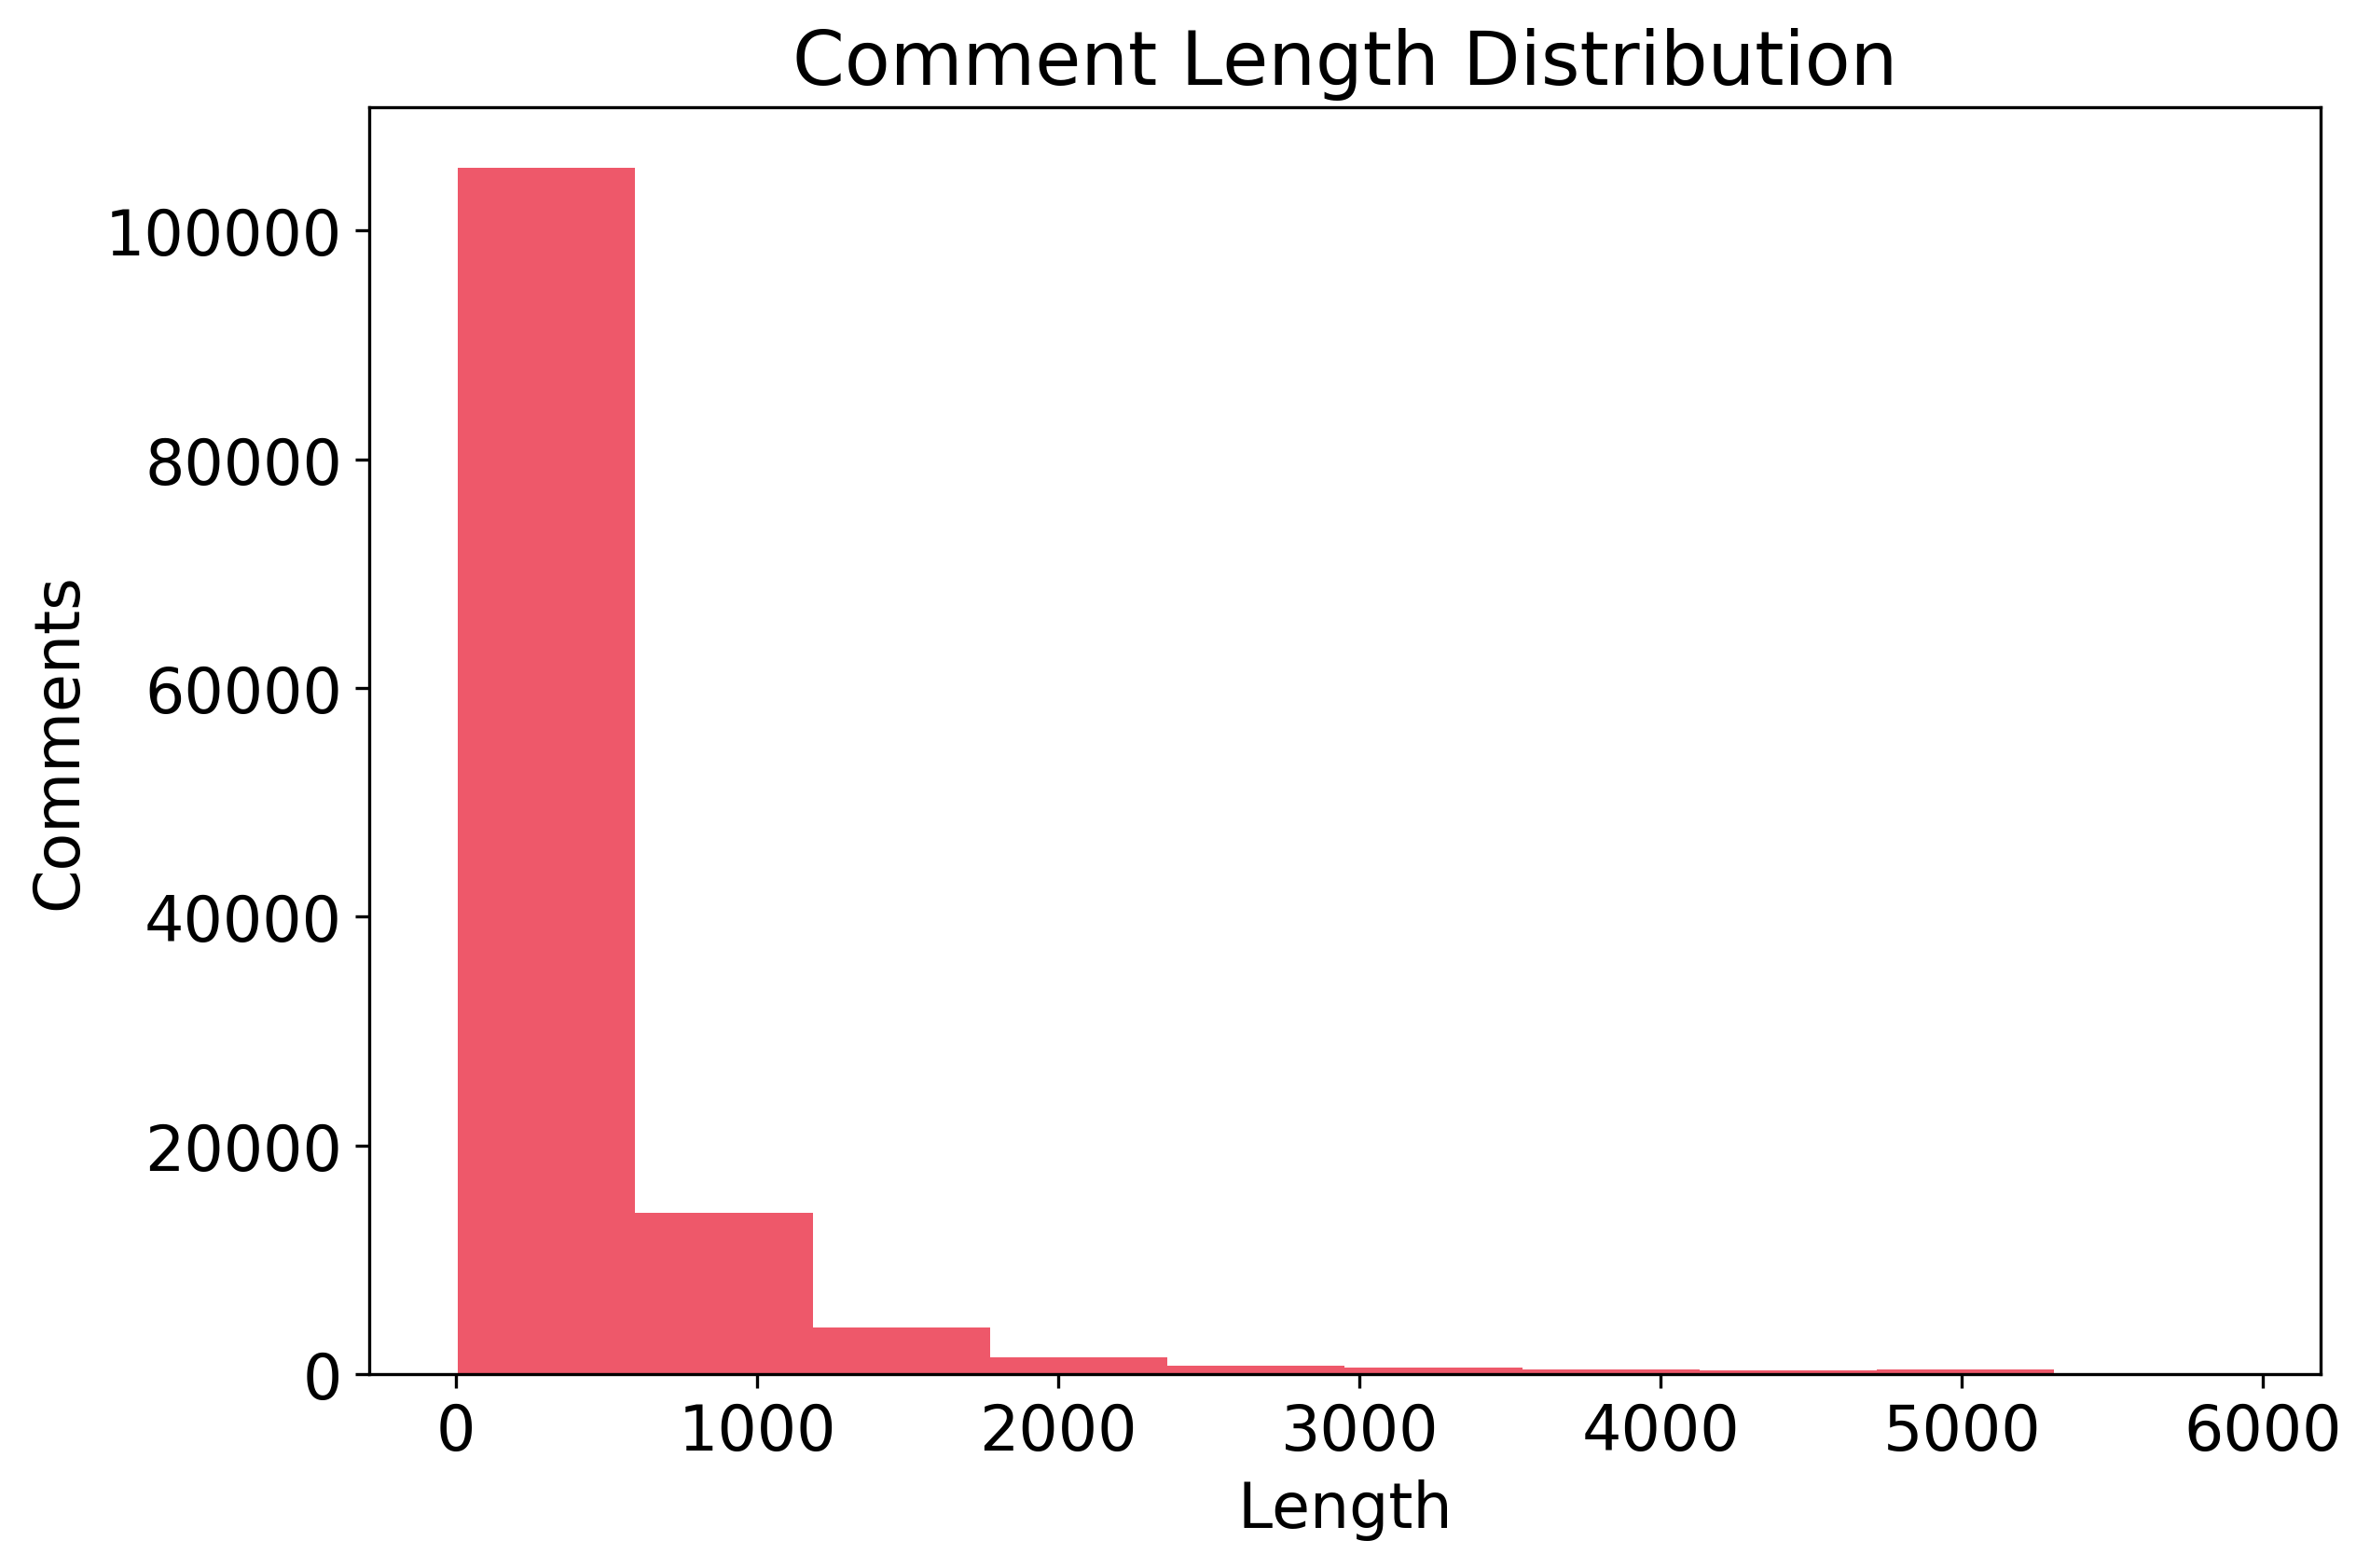

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,140030,ed56f082116dcbd0,Grandma Terri Should Burn in Trash \nGrandma T...,1,0,0,0,0,0,False
1,159124,f8e3cd98b63bf401,", 9 May 2009 (UTC)\nIt would be easiest if you...",0,0,0,0,0,0,True
2,60006,a09e1bcf10631f9a,"""\n\nThe Objectivity of this Discussion is dou...",0,0,0,0,0,0,True
3,65432,af0ee0066c607eb8,Shelly Shock\nShelly Shock is. . .( ),0,0,0,0,0,0,True
4,154979,b734772b1a807e09,I do not care. Refer to Ong Teng Cheong talk p...,0,0,0,0,0,0,True


In [100]:
def dataExploration(trainData):   
    # look at the top five rows of the train data file
    # training data contains a row per comment, with an id, 
    # the text of the comment, and 6 different labels
    trainData.head()
    
    # exampel of a comment in the train data
    print (trainData['comment_text'][0])
    print ("")
    
    # the length of the comments varies a lot   
    lens = trainData.comment_text.str.len()
    print("Average length of comments: %d\nStandard dev: %d\nLongest Comment: %d" % (lens.mean(), lens.std(), lens.max()))
    
    print ("")
    print ("# Comments in train data: %d \n# Comments in test data: %d" % (len(train),len(test)))
    fig = plt.figure(figsize=(9,6), dpi=300)
    ax = lens.hist(color=red)
    ax.grid(False)
    ax.set_facecolor('white')
    plt.title('Comment Length Distribution')
    plt.xlabel('Length')
    plt.ylabel('Comments')
    #plt.savefig('images/analysis/comment_length_hist_rect_transparent.png', bbox_inches='tight', transparent=True)
    plt.show()
    plt.clf()
    
dataExploration(train)
train.head()

In [117]:
np.min(train.comment_text.str.len())

6

# Toxic Class Frequency

In [10]:
palette= sns.color_palette(red_list_desc)

x=train.iloc[:,3:].sum()
x = x.sort_values(ascending=False)
plt.figure(figsize=(9,6), dpi=300)
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Number of comments per class")
plt.ylabel('Comments', fontsize=12)
plt.xlabel('Class')
rects = ax.patches
labelz = x.values
for rect, label in zip(rects, labelz):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.savefig('images/analysis/class_freq_toxic_only_rect_with_margin.jpg')
plt.clf()

# Toxic Class Frequency including Clean 

In [6]:
rowsums=train.iloc[:,3:].sum(axis=1)
train['clean']=(rowsums==0)
train['clean'].sum()

114675

<Figure size 432x288 with 0 Axes>

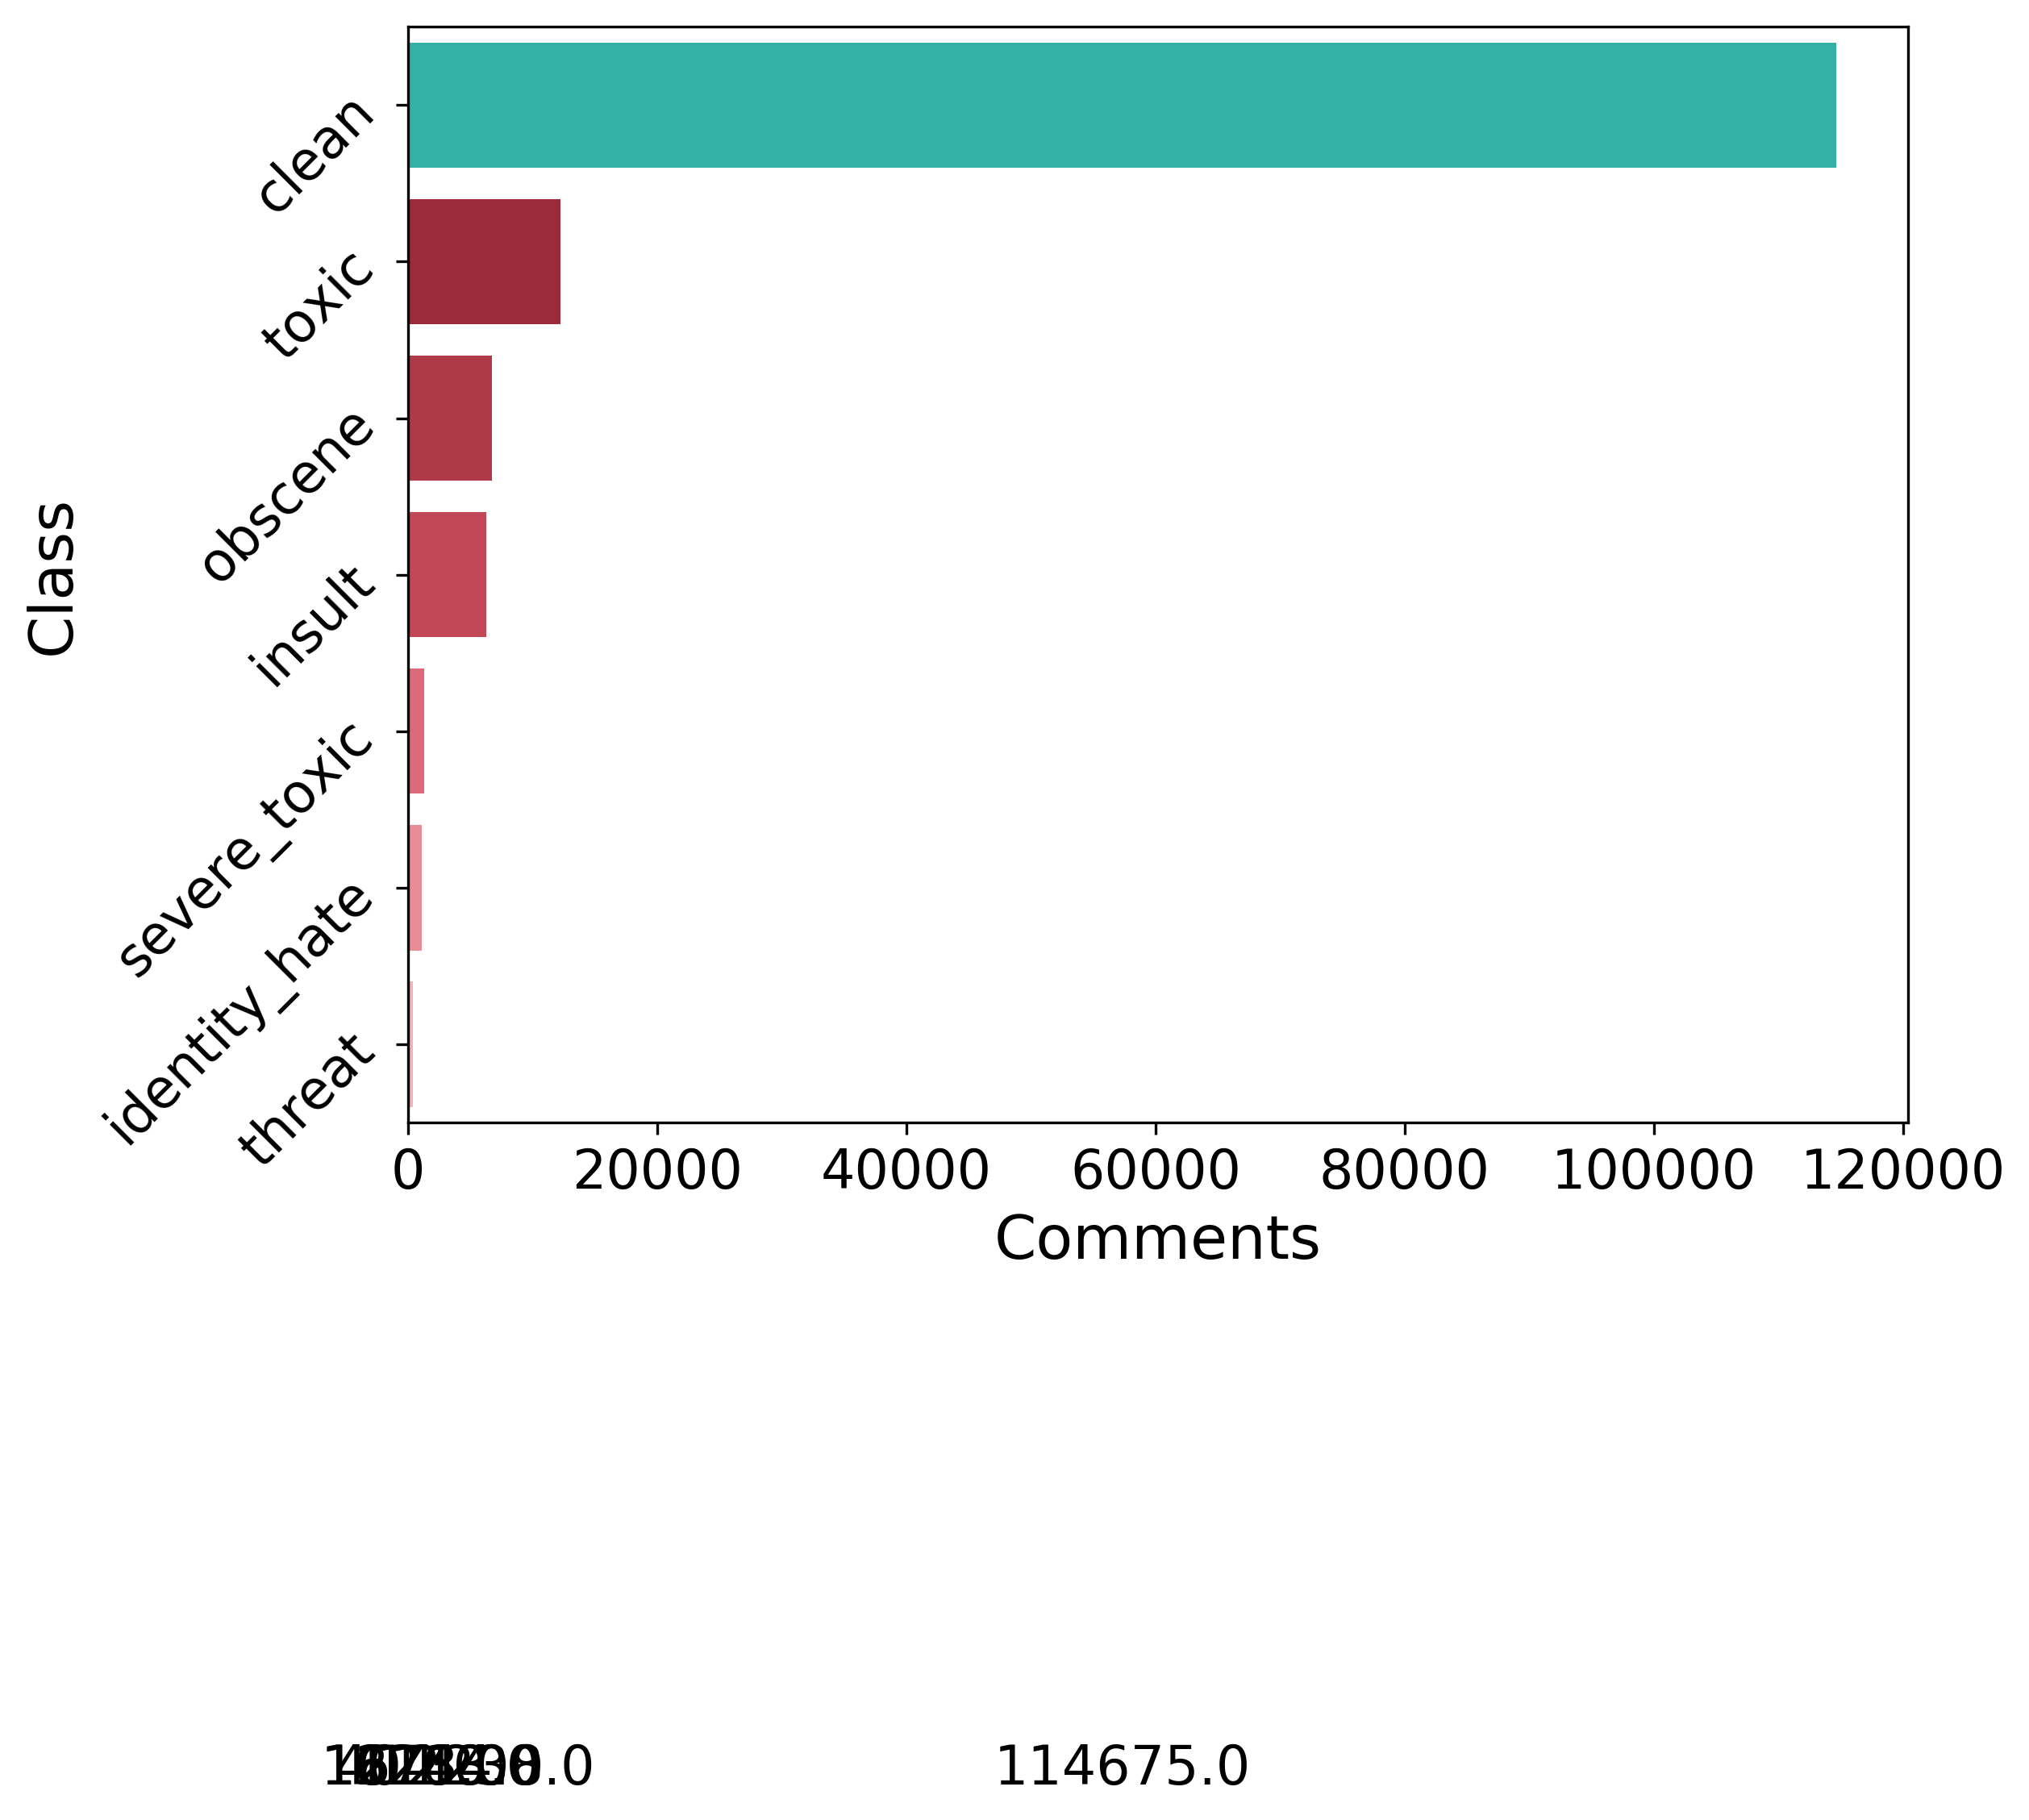

In [99]:
palette= sns.color_palette(green_red_list)

x=train.iloc[:,3:].sum()
x = x.sort_values(ascending=False)
plt.figure(figsize=(8,6), dpi=300)
ax= sns.barplot(x.values, x.index,palette=palette)
#plt.title("Number of comments per class")
plt.ylabel('Class', fontsize=18)
plt.yticks(rotation=45)
plt.xlabel('Comments', fontsize=18)

rects = ax.patches
labelz = x.values
#plt.tight_layout()
for rect, label in zip(rects, labelz):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')
plt.savefig('images/analysis/class_freq_all_rect_with_margin_2.jpg', bbox_inches='tight', pad_inches=0.275)
plt.show()
plt.clf()

# Word Clouds

In [8]:
toxic=train[train.toxic==1]['comment_text'].values
severe_toxic=train[train.severe_toxic==1]['comment_text'].values
obscene=train[train.obscene==1]['comment_text'].values
threat=train[train.threat==1]['comment_text'].values
insult=train[train.insult==1]['comment_text'].values
identity_hate=train[train.identity_hate==1]['comment_text'].values
clean=train[train.clean==1]['comment_text'].values

In [51]:

def show_cloud(title, word_list, bg_color, mask_path, file_name=None, show=True):
    mask=np.array(Image.open(mask_path))
    mask=mask[:,:,1]
    plt.figure(figsize=(10,10), dpi=300)
    wc = WordCloud(max_words=400, mask=mask
                 , stopwords=STOPWORDS, max_font_size= 80, collocations=False, random_state=5)
    wc.generate(" ".join(word_list))
    plt.title(title +" Comments - WordCloud", fontsize=24)
    # plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    plt.imshow(wc.recolor( colormap= cmap, random_state=1), alpha=0.98)
    plt.axis('off')
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()
        
wordcloud_bgs = ['white', light_grey, grey]
wordcloud_exts = ['light', 'medium', 'dark']

## The wordcloud of Toxic Comments


In [50]:
for i in range(3):
    show_cloud(title="Toxic", 
               word_list=toxic, 
               bg_color=wordcloud_bgs[i], 
               mask_path='images/toxic_logo.jpg', 
               file_name="images/wordcloud/wordcloud_toxic_"+wordcloud_exts[i]+".jpg", 
               show=False)

## The wordcloud of Severe Toxic Comments


In [40]:
for i in range(3):
    show_cloud(title="Severe Toxic", 
               word_list=severe_toxic, 
               bg_color=wordcloud_bgs[i], 
               mask_path='images/toxic_logo.jpg', 
               file_name="images/wordcloud/wordcloud_severe_toxic_"+wordcloud_exts[i]+".jpg", 
               show=False)

## The wordcloud of Threat Comments


In [41]:
for i in range(3):
    show_cloud(title="Threat", 
               word_list=threat, 
               bg_color=wordcloud_bgs[i], 
               mask_path='images/toxic_logo.jpg', 
               file_name="images/wordcloud/wordcloud_threat_"+wordcloud_exts[i]+".jpg", 
               show=False)

## The wordcloud of Obscene Comments


In [ ]:
for i in range(3):
    show_cloud(title="Obscene", 
               word_list=obscene, 
               bg_color=wordcloud_bgs[i], 
               mask_path='images/toxic_logo.jpg', 
               file_name="images/wordcloud/wordcloud_obscene_"+wordcloud_exts[i]+".jpg", 
               show=False)

## The wordcloud of Insult Comments


In [42]:
for i in range(3):
    show_cloud(title="Insult", 
               word_list=insult, 
               bg_color=wordcloud_bgs[i], 
               mask_path='images/toxic_logo.jpg', 
               file_name="images/wordcloud/wordcloud_insult_"+wordcloud_exts[i]+".jpg", 
               show=False)

## The wordcloud of Identity Hate Comments

In [43]:
for i in range(3):
    show_cloud(title="Identity Hate", 
               word_list=identity_hate, 
               bg_color=wordcloud_bgs[i], 
               mask_path='images/toxic_logo.jpg', 
               file_name="images/wordcloud/wordcloud_identity_hate_"+wordcloud_exts[i]+".jpg", 
               show=False)

## Clean Comments Word Cloud

In [44]:
for i in range(3):
    show_cloud(title="Clean", 
               word_list=clean, 
               bg_color=wordcloud_bgs[i], 
               mask_path='images/thumbs_logo.jpg', 
               file_name="images/wordcloud/wordcloud_clean_"+wordcloud_exts[i]+".jpg", 
               show=False)

# Most Frequent Words per Category

In [5]:
word_vec = TfidfVectorizer(ngram_range=(1,1),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, analyzer='word', stop_words='english')

In [6]:
def category_to_tfidf(category):
    tvec_weights = word_vec.fit_transform(category)
    weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': word_vec.get_feature_names(), 'weight': weights})
    return(weights_df.sort_values(by='weight', ascending=False).head(10))

In [9]:
toxic_idf=category_to_tfidf(toxic)
severe_toxic_idf=category_to_tfidf(severe_toxic)
threat_idf=category_to_tfidf(threat)
insult_idf=category_to_tfidf(insult)
obscene_idf=category_to_tfidf(obscene)
identity_hate_idf=category_to_tfidf(identity_hate)
toxic_idf

,term,weight
3264,fuck,0.035391
3278,fucking,0.020641
4609,like,0.017158
8354,wikipedia,0.016855
2471,don,0.016808
6907,shit,0.015957
4348,just,0.015559
5533,page,0.014908
7350,stop,0.012973
1087,bitch,0.012490


<Figure size 432x288 with 0 Axes>

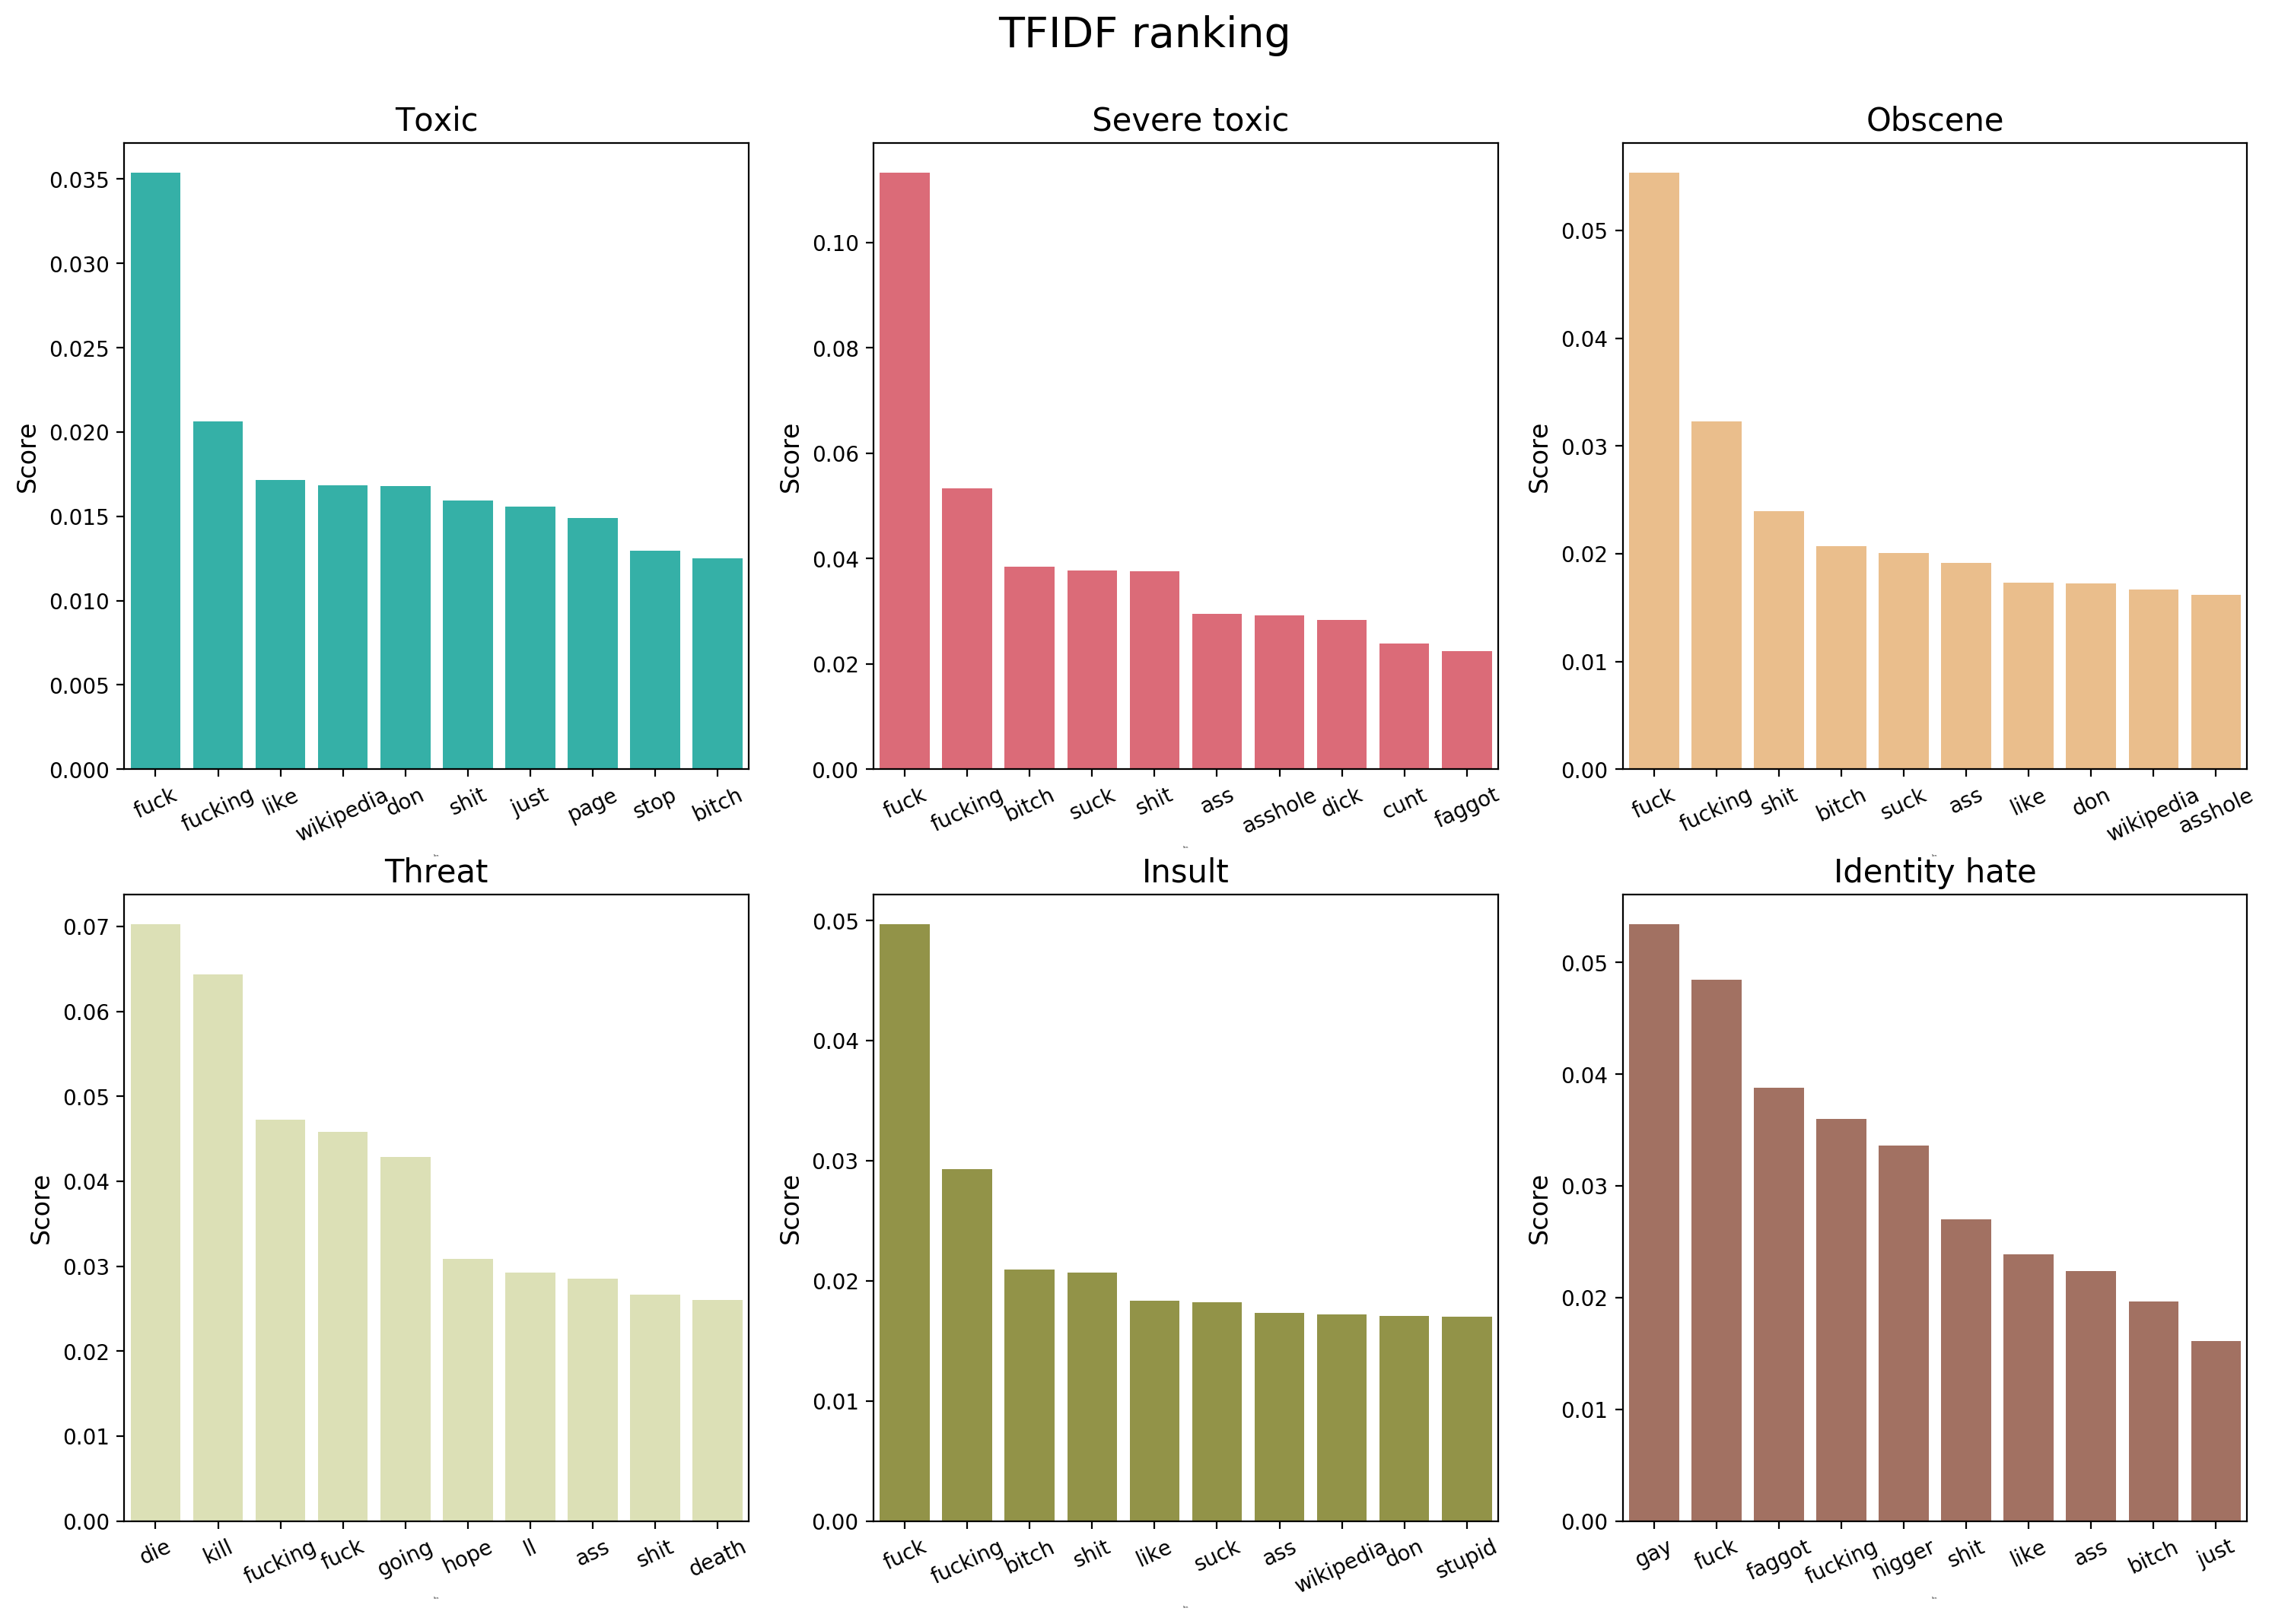

In [11]:
color_list = colors_list
rotation = 25
text_col = 'black'
plt.figure(figsize=(18,12), dpi=200)
plt.suptitle("TFIDF ranking ",fontsize=20, y = 0.95, color=text_col)
gridspec.GridSpec(2,3)
plt.subplot2grid((2,3),(0,0))
sns.barplot(toxic_idf.term,
            toxic_idf.weight,color=color_list[1])
plt.title("Toxic",fontsize=15, color=text_col)
plt.ylabel('Score', fontsize=12, color=text_col)
plt.xlabel('Term', fontsize=1, color=text_col)
plt.xticks(rotation=rotation, color=text_col)
plt.yticks(color=text_col)

plt.subplot2grid((2,3),(0,1))
sns.barplot(severe_toxic_idf.term,
            severe_toxic_idf.weight,color=color_list[0])
plt.title(" Severe toxic",fontsize=15, color=text_col)
plt.ylabel('Score', fontsize=12, color=text_col)
plt.xlabel('Term', fontsize=1, color=text_col)
plt.xticks(rotation=rotation, color=text_col)
plt.yticks(color=text_col)


plt.subplot2grid((2,3),(0,2))
sns.barplot(obscene_idf.term,
            obscene_idf.weight,color=color_list[2])
plt.title("Obscene",fontsize=15, color=text_col)
plt.ylabel('Score', fontsize=12, color=text_col)
plt.xlabel('Term', fontsize=1, color=text_col)
plt.xticks(rotation=rotation, color=text_col)
plt.yticks(color=text_col)


plt.subplot2grid((2,3),(1,0))
sns.barplot(threat_idf.term,
            threat_idf.weight,color=color_list[3])
plt.title("Threat",fontsize=15, color=text_col)
plt.ylabel('Score', fontsize=12, color=text_col)
plt.xlabel('Term', fontsize=1, color=text_col)
plt.xticks(rotation=rotation, color=text_col)
plt.yticks(color=text_col)


plt.subplot2grid((2,3),(1,1))
sns.barplot(insult_idf.term,
            insult_idf.weight,color=color_list[4])
plt.title("Insult",fontsize=15, color=text_col)
plt.ylabel('Score', fontsize=12, color=text_col)
plt.xlabel('Term', fontsize=1, color=text_col)
plt.xticks(rotation=rotation, color=text_col)
plt.yticks(color=text_col)


plt.subplot2grid((2,3),(1,2))
sns.barplot(identity_hate_idf.term,
            identity_hate_idf.weight,color=color_list[5])
plt.title("Identity hate",fontsize=15, color=text_col)
plt.ylabel('Score', fontsize=12, color=text_col)
plt.xlabel('Term', fontsize=1, color=text_col)
plt.xticks(rotation=rotation, color=text_col)
plt.yticks(color=text_col)

plt.savefig('images/analysis/word_freq_tfidf_3x2_light_bg.png', bbox_inches='tight')
plt.show()
plt.clf()

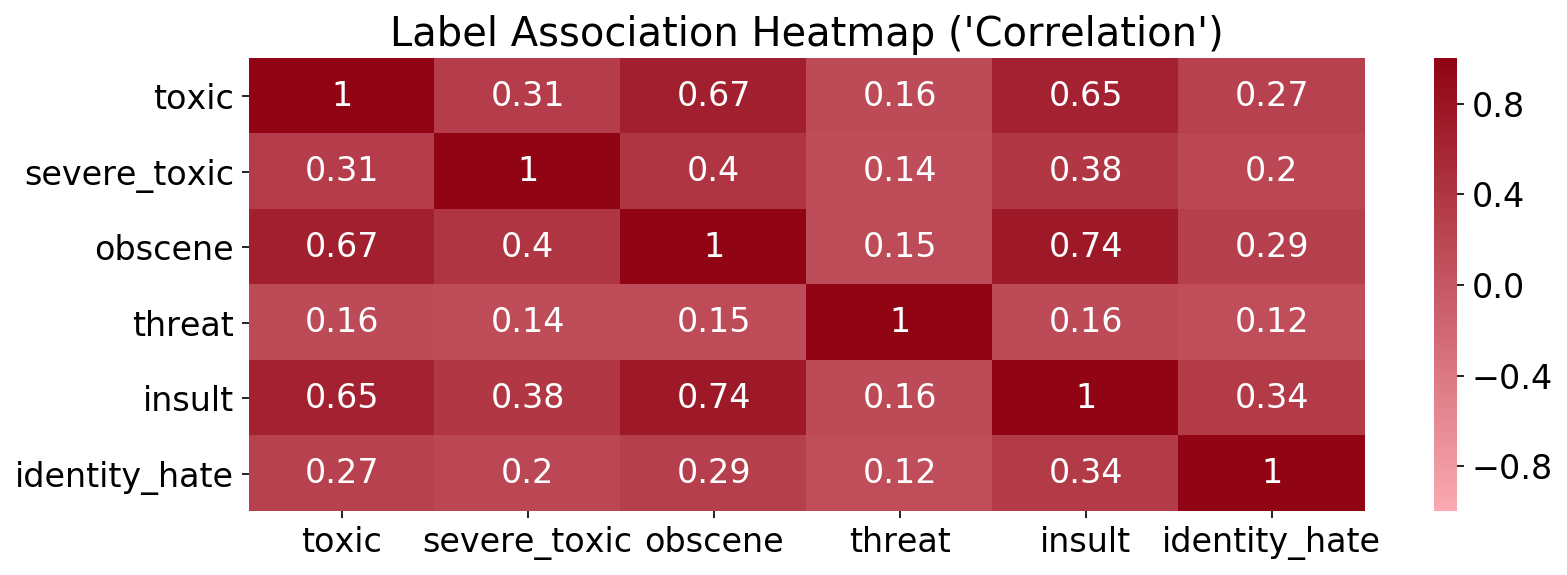

In [53]:
tox_labels = train[labels].copy()
rowsums = tox_labels.sum(axis=1)
train['clean']=(rowsums==0)
tox_labels['clean']=train['clean'].copy()
x = tox_labels.sum().copy()
# create a 1 X 2 grid
plt.figure(figsize=(12,4), dpi=150)
#gs = gridspec.GridSpec(0, 0, wspace=0.1)
font = {'family' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
# corr matrix
corr = tox_labels[labels].corr()

# heatmap
sns.heatmap(corr, cmap=cmap2,
            xticklabels=corr.columns.values, vmin = -1.0, vmax = 1.0,
            yticklabels=corr.columns.values, annot=True) 
plt.title("Label Association Heatmap ('Correlation')")
plt.savefig('images/analysis/correlation_matrix_sq_margin.png', bbox_inches='tight', pad_inches=0.275)
plt.show()